# Wavefront Sensing - Optics Project

In [4]:
import pandas as pd
import sympy as sp
import numpy as np
import math
import scipy as spy
import scipy.special as special
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit

from sympy import Symbol 
from sympy import symbols 
from sympy import *
from sympy import Integral, oo, exp, pi, integrate
from sympy import oo
from sympy import sinc
infinity=oo
k,a,y,f,phi = symbols("k,a,y,f,phi")
init_printing(use_unicode=False, wrap_line=False)

### Part 1 - Obtaining the power via integrating the intensity on the detectors, found from Fourier-Transforming a top-hat function input electric field through a single slit aperture in y. The intensity is the following integrand, in units of Watts/Meter due to being in 1D (y)

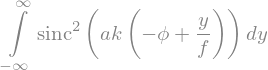

In [5]:
integrate((sinc(k*a*(y/f-phi)))**2,(y,-infinity,infinity))

In [6]:
k=2*np.pi/(632.8e-9) #(in inverse meters)
a=1e-5 #(in meters)
f=0.10 #(in meters)
phi=0.000632 #(i..e. 1λ deviation over a 1mm wide beam)

#power on detector 2 (lower)

def sinc_int(y, a, k, f, phi):
    return (special.sinc(k*a*(y/f-phi)))**2

p2 = quad(sinc_int, -infinity,0, args=(a,k,f,phi))
p2

#p2 = Integral((special.sinc(k*a*(y/f-phi)))**2,(y,-oo,0))
#f = lambdify(phi, p2, modules={"Integral": integral_as_quad})
#p2 = sp.lambdify([phi,y],p2,"numpy")
#f(.01)

<ipython-input-6-c324182280ce>:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p2 = quad(sinc_int, -infinity,0, args=(a,k,f,phi))


In [ ]:
#power on detector 1 (upper)
p1 = quad(sinc_int,0,infinity, args=(a,k,f,phi))
#p1 = p1.evalf(sub)
p1

In [ ]:
#S = p(detector1)-p(detector2)
signal = p1[0] - p2[0]
print('Power on detector 1 is: ', p1,'W')
print('Power on detector 2 is: ', p2,'W')
print('The total signal is: ', signal,'W')

In [ ]:
N=100

angle = np.linspace(-.01,.01,N).reshape(N)
power_plt = np.zeros(N)

for i in range(N):
    phi = angle[i]
    sig1 = quad(sinc_int, 0, infinity, args=(a,k,f,phi))
    sig2 = quad(sinc_int, -infinity, 0, args=(a,k,f,phi))
    power_plt[i] = sig1[0] - sig2[0]
    
#Interpolate between any two data points


    
print(power_plt)

In [ ]:
#Interpolation scheme to pick out phase gradient, phi

#Enter your measured power on the detectors

p_new = eval(input('Enter total signal power measured on both detectors: '))

#Find closest two power data points to interpolate between
def closest_values(input_array, input_value):
    arr = input_array #Takes in power values s = p1-p2
    if input_value > 0: #For positive values on x-axis we're interpolating
        k = (np.abs(arr - input_value)).argmin() #Index of smallest difference, to left.
        
        j = k-1
        return arr[j],arr[k],k,j #returns 4-element tuple 
    elif input_value < 0: #For negative input values
        k = (np.abs(arr - input_value)).argmin()
        
        j = k + 1 #Left of interpolation point
        return arr[j],arr[k],k,j
print(closest_values(power_plt,p_new))
p=closest_values(power_plt,p_new)[0:2] #Picks out first two values of Tuple 
print("The closest value to the "+ str(p_new)+" is",p)

#p = list(closest_values(power_plt,p_new))[0:2] #Turns first two tuple elements into list
k,j = list(closest_values(power_plt,p_new))[2:] #Turns last two tuple elements into list (indices)
#p = [power_plt[k],power_plt[j]]
ang = [angle[j], angle[k]] #phi at same indices as power


a_new = np.interp(p_new, p, ang) #Use numpy interp function to create estimated phi
print('The phase gradient is at',a_new,'rad.')
#End of interpolation scheme

#Plot phi(power) 
plt.figure(figsize=(16,16))
plt.plot(p, ang, "g-", p_new, a_new, '*r',markersize=8) #plots interpolation line and point
plt.plot(power_plt,angle,'g.') #plots data of N points
plt.grid(True)
plt.title('Power of signal vs. Tilt Angle')
plt.ylabel(r'Angle $\phi$ [rad]')
plt.xlabel('Signal power [Watts]')
plt.show()

### Part 2 - Inverting the Erf function to get tilt angle as a function of power, $\phi (p)$

In [ ]:
def sig_inv_fit(x,a,b,c): 
    return a*c*special.erfinv(b*x) #Erf with unknown parameters to take any power input to produce the tilt angle

[a,b,c], pcov = curve_fit(sig_inv_fit,power_plt,angle)  #Curve-fit to find parameters
[aerr,berr,cerr] = np.sqrt(np.diag(pcov)) 
 
print("a = ", a) 
print("a_err = ", aerr)  
print("b = ", b) 
print("b_err = ", berr)  
print("c = ", c) 
print("c_err = ", cerr)  

fit = sig_inv_fit(power_plt,a,b,c) #Creates fit and subs paramaters a,b,c

plt.figure(figsize=(10,10))
plt.plot(power_plt, fit, 'r-',
         label='fit: a=%5.3')
plt.plot(power_plt, angle, 'g*')

plt.xlabel('Power [Watts]')
plt.ylabel('Angle [rad]')
plt.legend()
plt.show()

In [ ]:
def siginv(x): #Creates the Erf Inverse function with same parameters
    return a*c*special.erfinv(b*x) 

power_input = eval(input('Enter the net power on detectors within range of above plot:'))
Tilt_Angle = siginv(power_input)
print('The tilt angle of the beam is: ',Tilt_Angle,'rad')

plt.figure(figsize=(10,10))
plt.plot(power_plt, siginv(power_plt), 'r-',
         label='fit: a=%5.3')
plt.plot(power_input,Tilt_Angle,'*c',markersize=10)
plt.xlabel('Signal Power')
plt.ylabel('Angle')
plt.legend()
plt.show()